### 2001-08-18 / traj_3120-3150_0006554589 / 49NZ200107_1

In [1]:
# eddy arguments
eddy_code = 'traj_3120-3150_0006554589'
eddy_list = [31]
# expo arguments
expo_code = '49NZ200107_1'
expo_list = '/home/cz2397/data/cchdo-ctd/225_p17n_2001a_nc_ctd/*_ctd.nc'
# eddy-expo arguments
STA, CAS = '70', 1

In [2]:
# packages
from ctd2xray import cchdo
from geopy.distance import great_circle
from mpl_toolkits.basemap import Basemap
from pymongo import MongoClient
import gsw
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
%matplotlib inline
# longitude
def range_180(lon):
    if lon < 180:
        lon = lon
    else:
        lon = lon - 360
    return lon
# eddy
rcs_eddies = MongoClient().eddies.rcs_eddies
eddy_rclv = rcs_eddies.find_one({'_id': eddy_code})
eddy_area = eddy_rclv['area']
eddy_lav = eddy_rclv['lav']
eddy_radius_meter = (eddy_area/np.pi)**0.5
earth_radius_meter = 6371000
eddy_radius_degree = (180*eddy_radius_meter)/(np.pi*earth_radius_meter)
eddy_traj = eddy_rclv['features'][2]['geometry']['coordinates']
lon_eddy = np.zeros(len(eddy_traj))
lat_eddy = np.zeros(len(eddy_traj))
for i in range(len(eddy_traj)):
    lon_eddy[i] = range_180(eddy_traj[i][0])
    lat_eddy[i] = eddy_traj[i][1]
lon_eddy_mean = lon_eddy.mean()
lat_eddy_mean = lat_eddy.mean()
if lat_eddy_mean > 0:
    if eddy_lav > 0:
        polarity = '#0000ff'
    elif eddy_lav < 0:
        polarity = '#ff0000'
elif lat_eddy_mean < 0:
    if eddy_lav > 0:
        polarity = '#ff0000'
    elif eddy_lav < 0:
        polarity = '#0000ff'
lon_edex = np.zeros(len(eddy_list))
lat_edex = np.zeros(len(eddy_list))
for i in range(len(eddy_list)):
    lon_edex[i] = range_180(eddy_traj[eddy_list[i]-1][0])
    lat_edex[i] = eddy_traj[eddy_list[i]-1][1]
lon_edex_mean = lon_edex.mean()
lat_edex_mean = lat_edex.mean()
# expo
cchdo_ctd = MongoClient().eddies.cchdo_ctd
lon_expo = np.zeros(cchdo_ctd.find({'expocode': expo_code}).count())
lat_expo = np.zeros(cchdo_ctd.find({'expocode': expo_code}).count())
i = 0
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    lon_expo[i] = expo['location']['coordinates'][0]
    lat_expo[i] = expo['location']['coordinates'][1]
    i = i+1
# eddy-expo
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    time = ds.time.values[0]
    lon = ds.longitude.values[0]
    lat = ds.latitude.values[0]
    station = str(ds.STATION_NUMBER)
    cast = int(ds.CAST_NUMBER)
    if station == STA and cast == CAS:
        TIM, LON, LAT = time, lon, lat
# titles
date = str(TIM)[0:10]
time = str(TIM)[11:13] + '-' + str(TIM)[14:16] + '-' + str(TIM)[17:19]
title_file = date + '_' + time
title_figure = date + ' / ' + eddy_code + ' / ' + expo_code
# climatology
url = 'https://data.nodc.noaa.gov/thredds/dodsC/woa/WOA13/DATA'
month = str(TIM)[5:7]
url_t = url + 'v2/temperature/netcdf/decav/0.25/woa13_decav_t' + month + '_04v2.nc'
cli_t = xr.open_dataset(url_t, decode_times=False)
lon_t = cli_t.lon.values[abs(cli_t.lon.values-LON).argmin()]
lat_t = cli_t.lat.values[abs(cli_t.lat.values-LAT).argmin()]
T = cli_t.sel(lon=lon_t, lat=lat_t).t_an.values[0]
DT = cli_t.depth.values
url_s = url + 'v2/salinity/netcdf/decav/0.25/woa13_decav_s' + month + '_04v2.nc'
cli_s = xr.open_dataset(url_s, decode_times=False)
lon_s = cli_s.lon.values[abs(cli_s.lon.values-LON).argmin()]
lat_s = cli_s.lat.values[abs(cli_s.lat.values-LAT).argmin()]
S = cli_s.sel(lon=lon_s, lat=lat_s).s_an.values[0]
DS = cli_s.depth.values
url_o = url + '/oxygen/netcdf/all/1.00/woa13_all_o' + month + '_01.nc'
cli_o = xr.open_dataset(url_o, decode_times=False)
lon_o = cli_o.lon.values[abs(cli_o.lon.values-LON).argmin()]
lat_o = cli_o.lat.values[abs(cli_o.lat.values-LAT).argmin()]
factor = 1025/22.4
O = cli_o.sel(lon=lon_o, lat=lat_o).o_an.values[0]*factor
DO = cli_o.depth.values
P = gsw.p_from_z(-DS, lat_s)
SA = gsw.SA_from_SP(S, P, lon_s, lat_s)
CT = gsw.CT_from_t(SA, T, P)

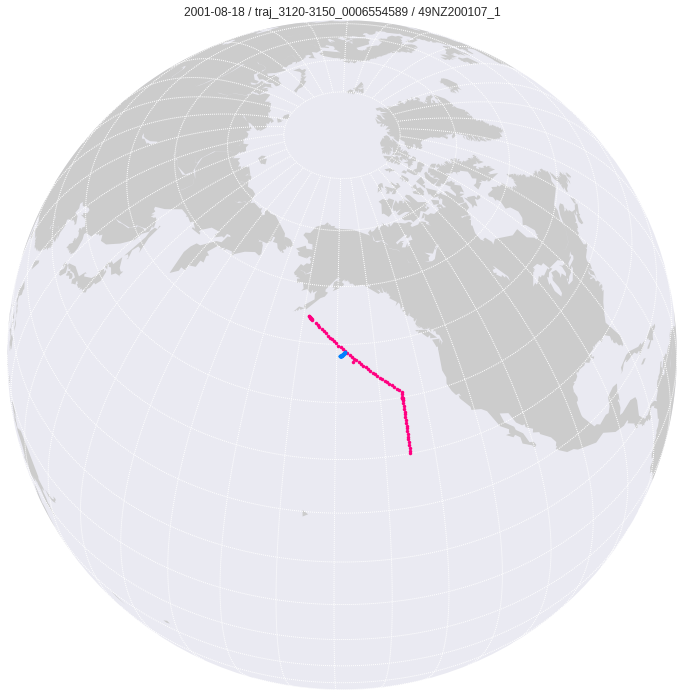

In [3]:
# figure 1 | global location
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)
my_map = Basemap(projection='ortho', resolution='c', 
                 lon_0=lon_eddy_mean, lat_0=lat_eddy_mean)
my_map.drawmapboundary('none')
my_map.drawmeridians(np.arange(0, 360, 10), color='#ffffff')
my_map.drawparallels(np.arange(-90, 90, 10), color='#ffffff')
my_map.fillcontinents()
x_eddy, y_eddy = my_map(lon_eddy, lat_eddy)
x_expo, y_expo = my_map(lon_expo, lat_expo)
my_map.plot(x_eddy, y_eddy, '.', color='#0080ff', zorder=20)
my_map.plot(x_expo, y_expo, '.', color='#ff0080', zorder=10)
plt.title(title_figure)
plt.savefig('figures/' + title_file + '/01_global-location.jpg')
plt.show()

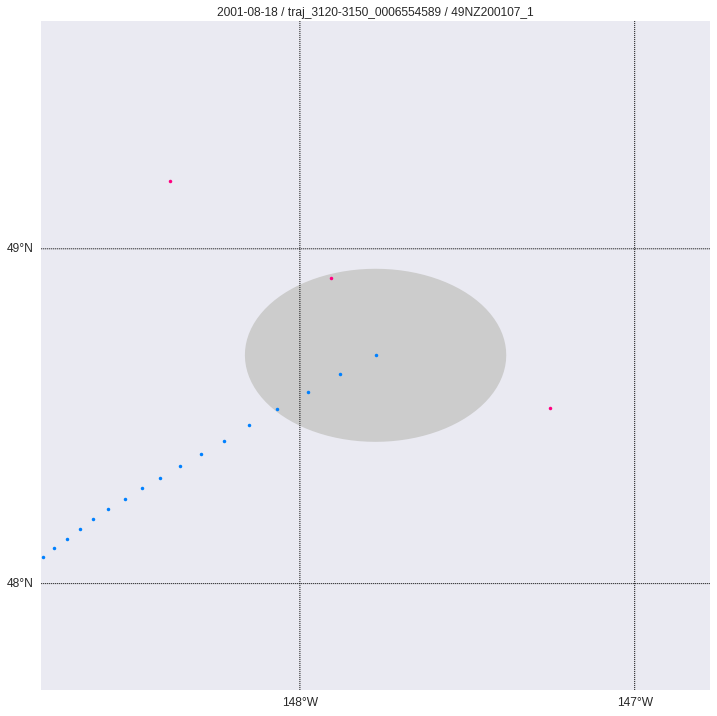

In [4]:
# figure 2 | regional location
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)
my_map = Basemap(projection='cyl', resolution='c',
                 llcrnrlat=lat_edex_mean-1, urcrnrlat=lat_edex_mean+1,
                 llcrnrlon=lon_edex_mean-1, urcrnrlon=lon_edex_mean+1)
my_map.tissot(lon_0=lon_edex_mean, lat_0=lat_edex_mean, radius_deg=eddy_radius_degree,
              npts=100, fc='#cccccc', ec='none', zorder=1)
my_map.fillcontinents()
my_map.drawmeridians(np.arange(0, 360, 1), labels=[0, 0, 0, 1])
my_map.drawparallels(np.arange(-90, 90, 1), labels=[1, 0, 0, 0])
x_eddy, y_eddy = my_map(lon_eddy, lat_eddy)
x_expo, y_expo = my_map(lon_expo, lat_expo)
my_map.plot(x_eddy, y_eddy, '.', color='#0080ff')
my_map.plot(x_expo, y_expo, '.', color='#ff0080')
plt.title(title_figure)
plt.savefig('figures/' + title_file + '/02_regional-location.jpg')
plt.show()

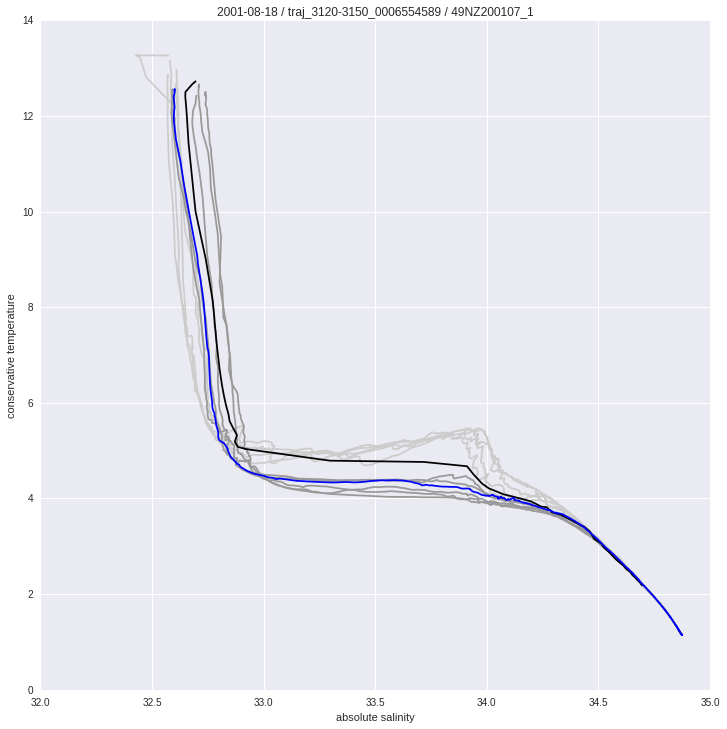

In [5]:
# figure 3 | temperature-salinity
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    lon = ds.longitude.values[0]
    lat = ds.latitude.values[0]
    p = ds.pressure.values
    t = ds.temperature.values
    s = ds.salinity.values
    sa = gsw.SA_from_SP(s, p, lon, lat)
    ct = gsw.CT_from_t(sa, t, p)
    station = str(ds.STATION_NUMBER)
    cast = int(ds.CAST_NUMBER)
    if station == STA and cast == CAS:
        plt.plot(sa, ct, color=polarity, zorder=4)
    elif station in ['65', '66', '67', '68', '69']:
        plt.plot(sa, ct, color='#cccccc', zorder=1)
    elif station in ['71', '72', '73', '74', '75']:
        plt.plot(sa, ct, color='#999999', zorder=2)
plt.plot(SA, CT, color='#000000', zorder=3)
plt.title(title_figure)
plt.xlabel('absolute salinity')
plt.ylabel('conservative temperature')
plt.savefig('figures/' + title_file + '/03_temperature-salinity.jpg')
plt.show()

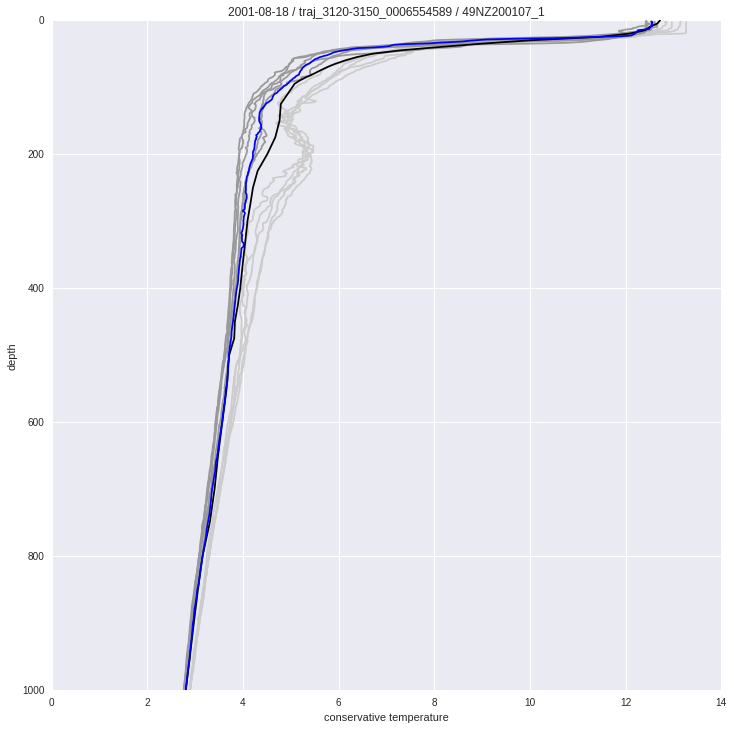

In [6]:
# figure-4 | temperature profile
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    lon = ds.longitude.values[0]
    lat = ds.latitude.values[0]
    p = ds.pressure.values
    d = -gsw.z_from_p(p, lat)
    t = ds.temperature.values
    s = ds.salinity.values
    sa = gsw.SA_from_SP(s, p, lon, lat)
    ct = gsw.CT_from_t(sa, t, p)
    station = str(ds.STATION_NUMBER)
    cast = int(ds.CAST_NUMBER)
    if station == STA and cast == CAS:
        plt.plot(ct, d, color=polarity, zorder=4)
    elif station in ['65', '66', '67', '68', '69']:
        plt.plot(ct, d, color='#cccccc', zorder=1)
    elif station in ['71', '72', '73', '74', '75']:
        plt.plot(ct, d, color='#999999', zorder=2)
plt.plot(CT, DT, color='#000000', zorder=3)
plt.title(title_figure)
plt.xlabel('conservative temperature')
plt.ylabel('depth')
plt.ylim([1000, 0])
plt.savefig('figures/' + title_file + '/04_temperature-profile.jpg')
plt.show()

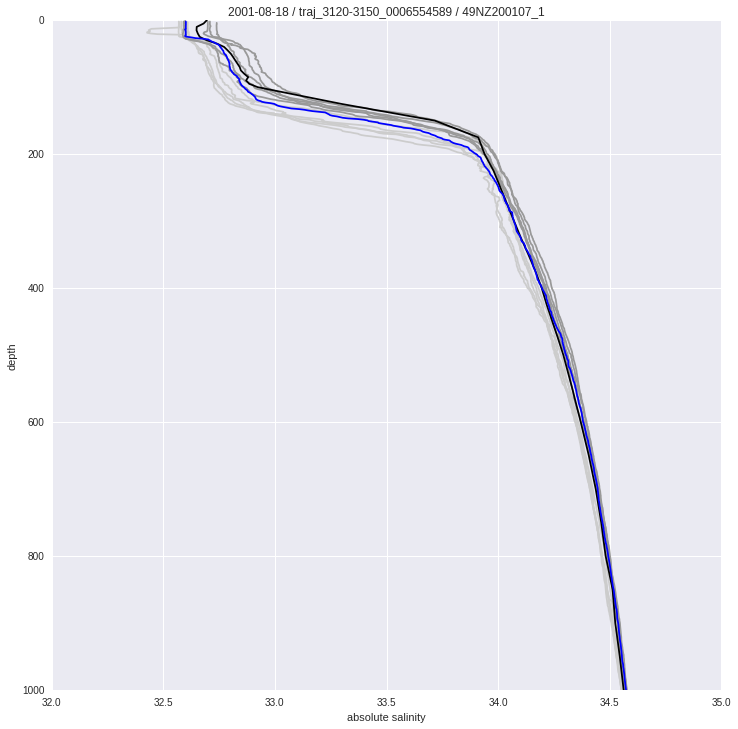

In [7]:
# figure-5 | salinity profile
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    lon = ds.longitude.values[0]
    lat = ds.latitude.values[0]
    p = ds.pressure.values
    d = -gsw.z_from_p(p, lat)
    s = ds.salinity.values
    sa = gsw.SA_from_SP(s, p, lon, lat)
    station = str(ds.STATION_NUMBER)
    cast = int(ds.CAST_NUMBER)
    if station == STA and cast == CAS:
        plt.plot(sa, d, color=polarity, zorder=4)
    elif station in ['65', '66', '67', '68', '69']:
        plt.plot(sa, d, color='#cccccc', zorder=1)
    elif station in ['71', '72', '73', '74', '75']:
        plt.plot(sa, d, color='#999999', zorder=2)
plt.plot(SA, DS, color='#000000', zorder=3)
plt.title(title_figure)
plt.xlabel('absolute salinity')
plt.ylabel('depth')
plt.ylim([1000, 0])
plt.savefig('figures/' + title_file + '/05_salinity-profile.jpg')
plt.show()

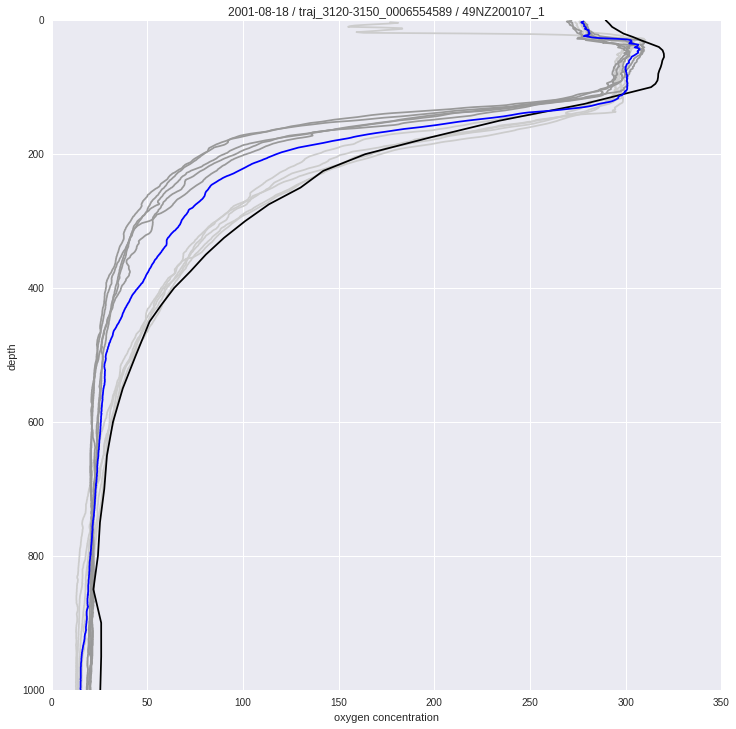

In [8]:
# figure-6 | oxygen profile
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    p = ds.pressure.values
    d = -gsw.z_from_p(p, lat)
    o = ds.oxygen.values
    station = str(ds.STATION_NUMBER)
    cast = int(ds.CAST_NUMBER)
    if station == STA and cast == CAS:
        plt.plot(o, d, color=polarity, zorder=4)
    elif station in ['65', '66', '67', '68', '69']:
        plt.plot(o, d, color='#cccccc', zorder=1)
    elif station in ['71', '72', '73', '74', '75']:
        plt.plot(o, d, color='#999999', zorder=2)
plt.plot(O, DO, color='#000000', zorder=3)        
plt.title(title_figure)
plt.xlabel('oxygen concentration')
plt.ylabel('depth')
plt.ylim([1000, 0])
plt.savefig('figures/' + title_file + '/06_oxygen-profile.jpg')
plt.show()

In [9]:
# section
pressure = np.linspace(0, 6000, num=6001, endpoint=True)
ds_tim = cchdo.open_cchdo_as_mfdataset(expo_list, pressure)
longitude = ds_tim.longitude.values
latitude = ds_tim.latitude.values
distance = np.zeros(len(ds_tim.time.values))
for i in range(1, len(distance)):
    origin = (latitude[i-1], longitude[i-1])
    termination = (latitude[i], longitude[i])
    distance[i] = great_circle(origin, termination).kilometers
dis_cum = np.cumsum(distance)
dis_index = ds_tim.longitude.values.tolist().index(LON)
DIS = dis_cum[dis_index]
dis_cum_reset = dis_cum - DIS
ds_tim['distance'] = xr.DataArray(dis_cum_reset, dims=ds_tim.time.dims, coords=ds_tim.time.coords)
ds_dis = ds_tim.swap_dims({'time': 'distance'})
ds_dis_subset = ds_dis.sel(pressure_i=slice(0, 500), distance=slice(-550, 550))
# gsw
s = ds_dis_subset.salinity_i.values
shape = s.shape
p = ds_dis_subset.salinity_i.pressure_i.values.reshape(1, shape[1])
p_bc = np.broadcast_to(p, shape)
lon = ds_dis_subset.salinity_i.longitude.values.reshape(shape[0], 1)
lon_bc = np.broadcast_to(lon, shape)
lat = ds_dis_subset.salinity_i.latitude.values.reshape(shape[0], 1)
lat_bc = np.broadcast_to(lat, shape)
sa = gsw.SA_from_SP(s, p_bc, lon_bc, lat_bc)
t = ds_dis_subset.temperature_i.values
ct = gsw.CT_from_t(sa, t, p_bc)
sigma = gsw.sigma0(sa, ct)
ds_dis_subset['ct_i'] = xr.DataArray(ct, dims=ds_dis_subset.temperature_i.dims, coords=ds_dis_subset.temperature_i.coords)
ds_dis_subset['sa_i'] = xr.DataArray(sa, dims=ds_dis_subset.salinity_i.dims, coords=ds_dis_subset.salinity_i.coords)
ds_dis_subset['sigma_i'] = xr.DataArray(sigma, dims=ds_dis_subset.oxygen_i.dims, coords=ds_dis_subset.oxygen_i.coords)

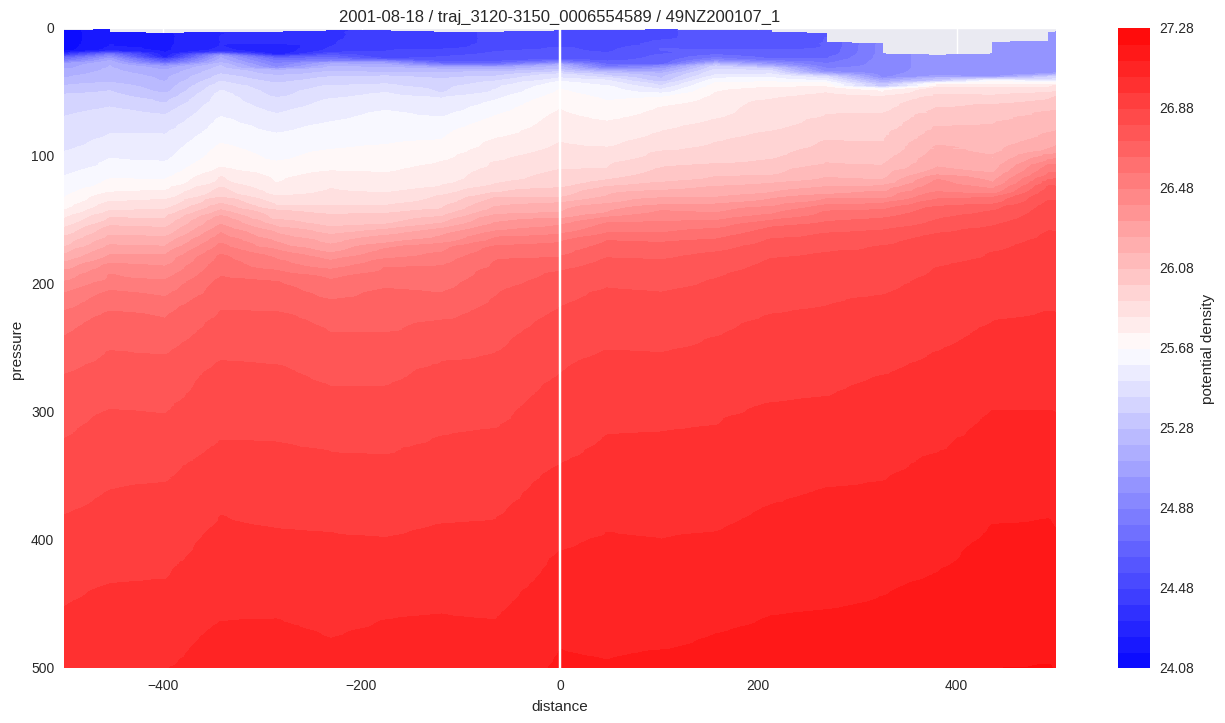

In [14]:
# figure-7 | density section
sns.set()
plt.rcParams['figure.figsize'] = (16, 8)
image = ds_dis_subset.sigma_i.T.plot.contourf(cmap='bwr', levels=50)
image.colorbar.set_label('potential density')
plt.title(title_figure)
plt.xlabel('distance')
plt.xlim([-500, 500])
plt.ylabel('pressure')
plt.ylim([500, 0])
plt.axvline(0, color='#ffffff')
plt.savefig('figures/' + title_file + '/07_density-section.jpg')
plt.show()

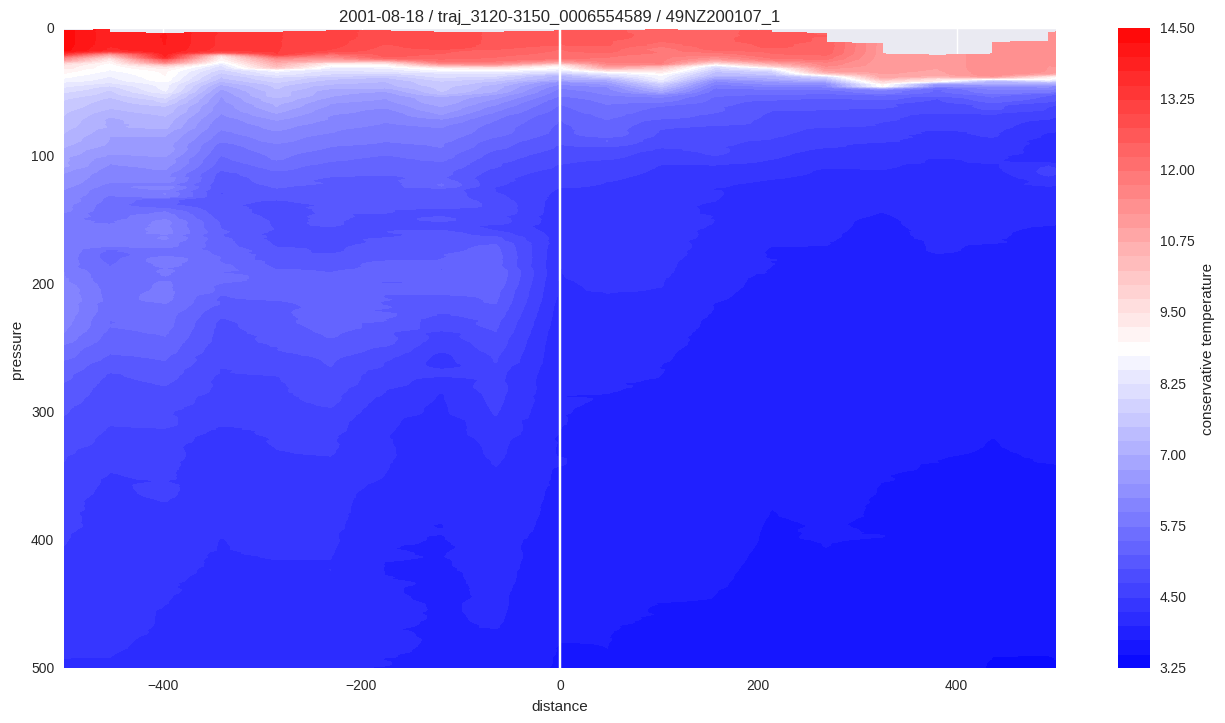

In [11]:
# figure-8 | temperature section
sns.set()
plt.rcParams['figure.figsize'] = (16, 8)
image = ds_dis_subset.ct_i.T.plot.contourf(cmap='bwr', levels=50)
image.colorbar.set_label('conservative temperature')
plt.title(title_figure)
plt.xlabel('distance')
plt.xlim([-500, 500])
plt.ylabel('pressure')
plt.ylim([500, 0])
plt.axvline(0, color='#ffffff')
plt.savefig('figures/' + title_file + '/08_temperature-section.jpg')
plt.show()

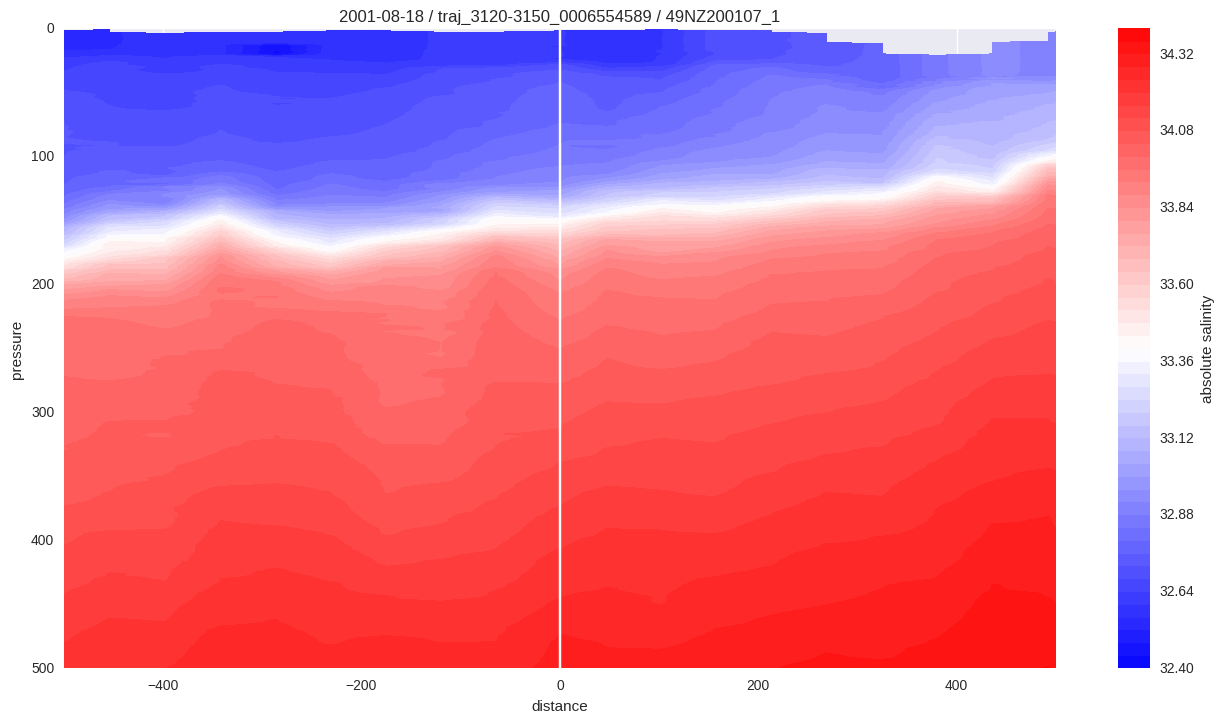

In [12]:
# figure-9 | salinity section
sns.set()
plt.rcParams['figure.figsize'] = (16, 8)
image = ds_dis_subset.sa_i.T.plot.contourf(cmap='bwr', levels=50)
image.colorbar.set_label('absolute salinity')
plt.title(title_figure)
plt.xlabel('distance')
plt.xlim([-500, 500])
plt.ylabel('pressure')
plt.ylim([500, 0])
plt.axvline(0, color='#ffffff')
plt.savefig('figures/' + title_file + '/09_salinity-section.jpg')
plt.show()

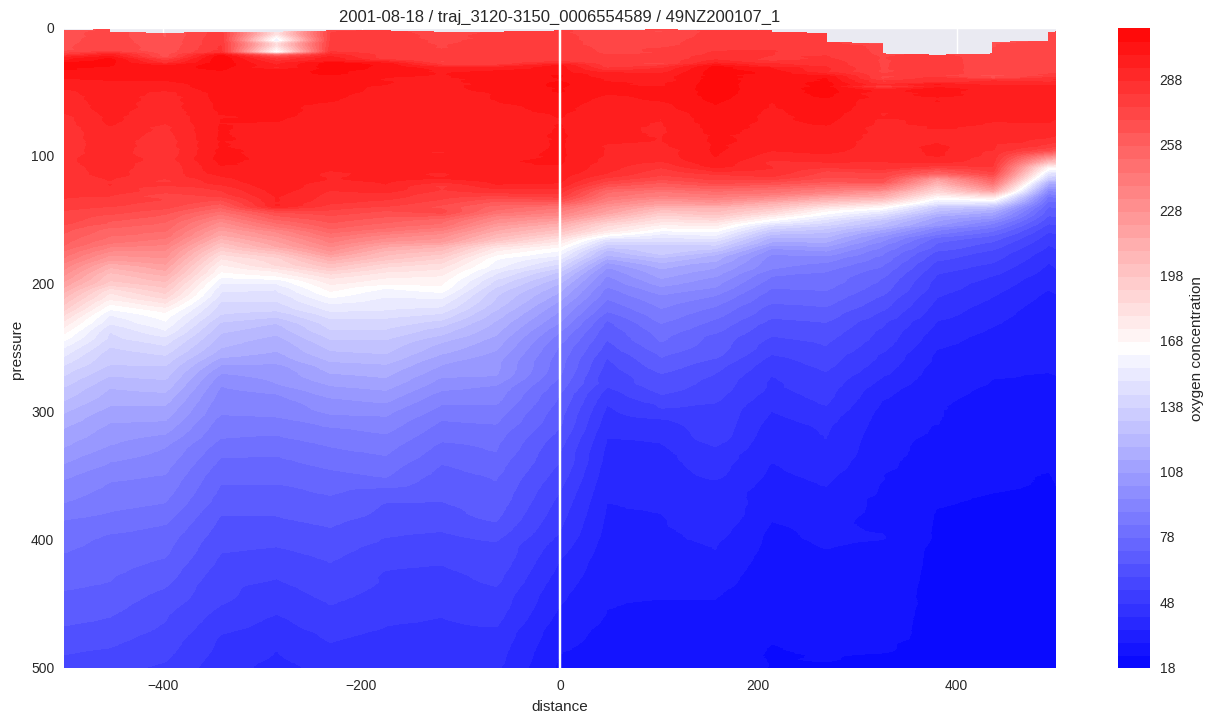

In [13]:
# figure-10 | oxygen section
sns.set()
plt.rcParams['figure.figsize'] = (16, 8)
image = ds_dis_subset.oxygen_i.T.plot.contourf(cmap='bwr', levels=50)
image.colorbar.set_label('oxygen concentration')
plt.title(title_figure)
plt.xlabel('distance')
plt.xlim([-500, 500])
plt.ylabel('pressure')
plt.ylim([500, 0])
plt.axvline(0, color='#ffffff')
plt.savefig('figures/' + title_file + '/10_oxygen-section.jpg')
plt.show()